## Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

query = """
SELECT 
    td.id,
    td.departure_date,
    td.train_number,
    td.relation,
    td.train_service,
    td.ptcar_number,
    td.line_number_departure,
    td.real_time_arrival,
    td.real_time_departure,
    td.planned_time_arrival,
    td.planned_time_departure,
    td.delay_arrival,
    td.delay_departure,
    ptcar.id AS ptcar_id,     
    ptcar.name AS name_travel,    
    td.line_number_arrival,
    dep.name AS departure_station_name,
    arr.name AS arrival_station_name,
    ptcar.longitude AS ptcar_longitude,  
    ptcar.latitude AS ptcar_latitude  
FROM train_data td
JOIN STATIONS ptcar ON td.ptcar_name = ptcar.id
JOIN STATIONS dep ON td.station_departure = dep.id
JOIN STATIONS arr ON td.station_arrival = arr.id
WHERE td.station_arrival = '487'  
  AND td.station_departure = '159'  
ORDER BY td.id;
"""

line = pd.read_sql(sqla.text(query), connection)
line =line.drop(columns=['train_service', 'relation'])

road = [159,151,149,150,156,157,154,245,773,132,310,365,422,300,628,614,591,
 540,118,178,235,281,480,108,642,625,623,557,558,384,199,559,645,123,195,73,
 261,560,187,438,172,342,341,80,503,629,267,313,608,339,452,564,493,
 317,704,757,70]

print("Road:", len(road))

tempo = []
clean = []
road_index = 0

for i, row in line.iterrows():
    ptcar_id = row['ptcar_id']
    if ptcar_id == road[road_index]:
        tempo.append(row)
        road_index += 1
        if len(tempo) == len(road):
            clean.extend(tempo)
            tempo = []
            road_index = 0
    else:
        tempo = []
        road_index = 0

clean_df = pd.DataFrame(clean)

query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)
clean_df= clean_df.drop(columns=['departure_station_name','arrival_station_name','id', 'name_travel', 'ptcar_number','ptcar_id'])
merged_df = pd.merge(clean_df, type_day, left_on='departure_date', right_on='date', how='left')
merged_df.loc[merged_df.index[::57], "delay_arrival"] = 0

merged_df.loc[merged_df.index[::57], "real_time_arrival"] = merged_df.loc[merged_df.index[::57], "real_time_departure"]
merged_df.loc[merged_df.index[::57], "planned_time_arrival"] = merged_df.loc[merged_df.index[::57], "planned_time_departure"]
merged_df.loc[merged_df.index[::57], "line_number_arrival"] = merged_df.loc[merged_df.index[::57], "line_number_departure"]


merged_df.loc[merged_df.index[56::57], "line_number_departure"] = 162
merged_df.loc[merged_df.index[56::57], "line_number_arrival"] = 162

index = merged_df.index[56::57]
mask = merged_df.loc[index, "real_time_departure"] == None
merged_df.loc[index, "real_time_departure"] = merged_df.loc[index, "real_time_arrival"]

mask = merged_df.loc[index, "planned_time_departure"] == None
merged_df.loc[index, "planned_time_departure"] = merged_df.loc[index, "planned_time_arrival"]

mask = merged_df.loc[index, "delay_departure"] == None
merged_df.loc[index, "delay_departure"] = merged_df.loc[index, "delay_arrival"]
#merged_df = merged_df.ffill(axis=1).bfill(axis=1)

query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)

print("In Loading...")

merged_df['time'] = pd.to_datetime(merged_df['planned_time_arrival'], format='%H:%M:%S')
merged_df['hour'] = merged_df['time'].dt.hour
final_df = pd.merge(merged_df, weather, left_on=['departure_date', 'hour'], right_on=['date', 'hour_of_day'], how='left')
final_df = final_df.drop(columns=['date_x', 'date_y', 'hour_of_day','time','hour'])

def parse_time_to_seconds(val):
    if pd.isna(val):
        return 0
    try:
        if isinstance(val, (int, float)):
            return int(val)
        if str(val).isdigit():
            return int(val)
        t = pd.to_datetime(val, format='%H:%M:%S', errors='coerce')
        if pd.isna(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0


final_df['departure_date'] = pd.to_datetime(final_df['departure_date'], format='%Y-%m-%d')

final_df['departure_year'] = final_df['departure_date'].dt.year
final_df['departure_month'] = final_df['departure_date'].dt.month
final_df['departure_day'] = final_df['departure_date'].dt.day
final_df['departure_weekday'] = final_df['departure_date'].dt.weekday

final_df['real_time_arrival'] = final_df['real_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_arrival'] = final_df['planned_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_departure'] = final_df['planned_time_departure'].apply(parse_time_to_seconds)
final_df['real_time_departure'] = final_df['real_time_departure'].apply(parse_time_to_seconds)

final_df = final_df.drop(columns=['departure_date', 'line_number_departure', 'line_number_arrival' ,'train_number'])
final_df['delay_arrival'] = final_df['delay_arrival'].apply(parse_time_to_seconds)

trajet_valid = []

for i in range(0, len(final_df), 57):
    trajet = final_df.iloc[i:i+57]
    if trajet.shape[0] < 57:
        print("Not enough data for this trajet, skipping")
        continue

    if trajet.isnull().values.any():
        print(f"Skipping trajet starting at index {i}: contains NaN")
        continue

    if trajet['delay_arrival'].abs().max() > 36000:
        print("Delay arrival exceeds 10000 seconds, skipping")
        continue

    trajet_valid.append(trajet)

trajet_valid_df = pd.concat(trajet_valid, ignore_index=True)
trajet_valid_df["stop_index"] = trajet_valid_df.index % 57

Connected to PostgreSQL successfully!
Road: 57
In Loading...
Skipping trajet starting at index 294804: contains NaN
Skipping trajet starting at index 1427622: contains NaN
Skipping trajet starting at index 1427679: contains NaN


##  Model 

In [6]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def create_dataset_multi(df, start_index=1, target_stops=range(2, 56), stops_per_trip=57):
    X_list = []
    Y_list = []
    features_columns = [
        'planned_time_arrival', 'planned_time_departure',
        'delay_arrival', 'delay_departure',
        'ptcar_latitude', 'ptcar_longitude',
        'holiday', 'weekend', 'day_after_rest',
        'avg_temperature', 'avg_dewpoint', 'avg_relative_humidity',
        'avg_precipitation', 'avg_snowfall', 'avg_wind_direction',
        'avg_wind_speed', 'avg_pressure',
        'departure_month', 'departure_day', 'departure_weekday', 'departure_year'
    ]
    
    for i in range(0, len(df), stops_per_trip):
        trajet = df.iloc[i:i+stops_per_trip]
        if trajet.shape[0] < stops_per_trip:
            continue
        features = trajet.iloc[start_index][features_columns].values
        targets = trajet.iloc[target_stops]['delay_arrival'].values  
        X_list.append(features)
        Y_list.append(targets)
    
    return np.array(X_list), np.array(Y_list)

X, Y = create_dataset_multi(trajet_valid_df)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
base_gb = GradientBoostingRegressor(random_state=42)

chain = RegressorChain(base_estimator=base_gb,order=list(range(Y_train.shape[1])),  random_state=1)

chain.fit(X_train,Y_train)

Y_pred_chain = chain.predict(X_test)

overall_r2_chain = r2_score(Y_test, Y_pred_chain)
overall_rmse_chain = np.sqrt(mean_squared_error(Y_test, Y_pred_chain))
print(f"Chain‐model overall R²: {overall_r2_chain:.4f}, RMSE: {overall_rmse_chain:.4f}")

r2_per_stop_chain = [r2_score(Y_test[:, i], Y_pred_chain[:, i])for i in range(Y_test.shape[1])]
for idx, r2_val in enumerate(r2_per_stop_chain, start=2):
    print(f"Stop {idx:2d} R² = {r2_val:.3f}")

Chain‐model overall R²: 0.4463, RMSE: 291.9494
Stop  2 R² = 0.970
Stop  3 R² = 0.942
Stop  4 R² = 0.928
Stop  5 R² = 0.825
Stop  6 R² = 0.810
Stop  7 R² = 0.738
Stop  8 R² = 0.704
Stop  9 R² = 0.695
Stop 10 R² = 0.682
Stop 11 R² = 0.677
Stop 12 R² = 0.648
Stop 13 R² = 0.623
Stop 14 R² = 0.593
Stop 15 R² = 0.582
Stop 16 R² = 0.559
Stop 17 R² = 0.519
Stop 18 R² = 0.519
Stop 19 R² = 0.512
Stop 20 R² = 0.512
Stop 21 R² = 0.510
Stop 22 R² = 0.467
Stop 23 R² = 0.460
Stop 24 R² = 0.418
Stop 25 R² = 0.414
Stop 26 R² = 0.404
Stop 27 R² = 0.387
Stop 28 R² = 0.354
Stop 29 R² = 0.356
Stop 30 R² = 0.347
Stop 31 R² = 0.341
Stop 32 R² = 0.345
Stop 33 R² = 0.343
Stop 34 R² = 0.338
Stop 35 R² = 0.324
Stop 36 R² = 0.324
Stop 37 R² = 0.325
Stop 38 R² = 0.321
Stop 39 R² = 0.302
Stop 40 R² = 0.293
Stop 41 R² = 0.295
Stop 42 R² = 0.292
Stop 43 R² = 0.295
Stop 44 R² = 0.297
Stop 45 R² = 0.266
Stop 46 R² = 0.247
Stop 47 R² = 0.221
Stop 48 R² = 0.229
Stop 49 R² = 0.225
Stop 50 R² = 0.240
Stop 51 R² = 0.201
Sto

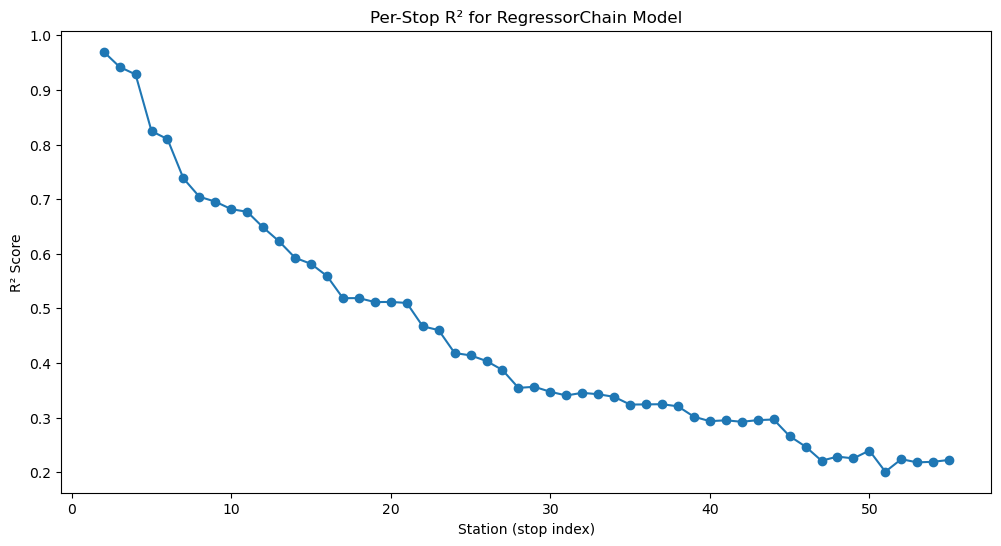

In [7]:
stops = list(range(2, 2 + len(r2_per_stop_chain)))

plt.figure(figsize=(12, 6))
plt.plot(stops, r2_per_stop_chain, marker='o')
plt.xlabel("Station (stop index)")
plt.ylabel("R² Score")
plt.title("Per-Stop R² for RegressorChain Model")
plt.show()

## Evaluation

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. Define a PyTorch Dataset
class DelayDataset(Dataset):
    def __init__(self, X, Y):
        # Ensure inputs are float32 numpy arrays
        X = np.asarray(X, dtype=np.float32)
        Y = np.asarray(Y, dtype=np.float32)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 2. Define the neural network model
class MultiOutputRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.2):
        super(MultiOutputRegressor, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# 3. Training & evaluation pipeline

def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_losses.append(criterion(preds, yb).item())

        print(f"Epoch {epoch}/{epochs}  Train Loss: {np.mean(train_losses):.4f}  Val Loss: {np.mean(val_losses):.4f}")

    return model

# 4. Putting it all together
if __name__ == '__main__':
    # Assuming X, Y are created by create_dataset_multi
    # Make sure create_dataset_multi returns float32 arrays:
    # X, Y = create_dataset_multi(trajet_valid_df)
    
    # Example for splitting and loading
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    train_dataset = DelayDataset(X_train, Y_train)
    test_dataset  = DelayDataset(X_test, Y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=32)

    # Model instantiation
    input_dim = train_dataset.X.shape[1]
    hidden_dims = [128, 64]
    output_dim = train_dataset.Y.shape[1]
    model = MultiOutputRegressor(input_dim, hidden_dims, output_dim)

    # Train
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = train_model(model, train_loader, test_loader, epochs=30, lr=1e-3, device=device)

    # Evaluation on test set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    Y_pred = np.vstack(all_preds)
    Y_true = np.vstack(all_targets)

    # Compute metrics
    overall_r2 = r2_score(Y_true, Y_pred)
    overall_rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    print(f"Neural-net overall R²: {overall_r2:.4f}, RMSE: {overall_rmse:.4f}")

    # Per-stop R2
    per_stop_r2 = [r2_score(Y_true[:, i], Y_pred[:, i]) for i in range(Y_true.shape[1])]
    for idx, val in enumerate(per_stop_r2, start=2):
        print(f"Stop {idx:2d} R² = {val:.3f}")


Epoch 1/30  Train Loss: 181384.4745  Val Loss: 137085.6527
Epoch 2/30  Train Loss: 131707.6498  Val Loss: 122158.2155
Epoch 3/30  Train Loss: 117681.2681  Val Loss: 98449.0585
Epoch 4/30  Train Loss: 110803.6174  Val Loss: 98422.2976
Epoch 5/30  Train Loss: 109732.4991  Val Loss: 97398.4638
Epoch 6/30  Train Loss: 110140.7654  Val Loss: 97810.3179
Epoch 7/30  Train Loss: 109179.0065  Val Loss: 99733.2247
Epoch 8/30  Train Loss: 106596.6166  Val Loss: 96710.3922
Epoch 9/30  Train Loss: 104211.9026  Val Loss: 99774.1727
Epoch 10/30  Train Loss: 101208.5021  Val Loss: 95740.3739
Epoch 11/30  Train Loss: 101160.0009  Val Loss: 98048.4066
Epoch 12/30  Train Loss: 100453.7021  Val Loss: 96351.2651
Epoch 13/30  Train Loss: 100622.4712  Val Loss: 96673.6484
Epoch 14/30  Train Loss: 99933.3706  Val Loss: 96685.8774
Epoch 15/30  Train Loss: 99769.9989  Val Loss: 100390.6842
Epoch 16/30  Train Loss: 99533.6625  Val Loss: 95055.8995
Epoch 17/30  Train Loss: 100001.5244  Val Loss: 95203.6141
Epoch 